## LIBS

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import time

from sklearn.svm import SVC
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.model_selection import GridSearchCV

from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold

from sklearn import metrics

## Train Data Load and Normalization

In [2]:
# training data path
training_data = pd.read_csv('./fashion-mnist_train.csv')

train_label = training_data['label']
train_X = training_data.drop('label',axis=1)

# do nomalization
train_X = train_X.astype('float32')
train_X /= 255.0

seed = 99
np.random.seed(seed)
X_train, X_val,label_train,label_val = train_test_split(train_X,train_label,test_size =0.1, random_state= seed)
# split train set and validation set

# do standard scaling (norm method)
X_train=StandardScaler().fit_transform(X_train)
X_val=StandardScaler().fit_transform(X_val)



## Test Data Load and Normalization

In [3]:
# test set load
import os
from PIL import Image
# data_dir -> 테스트 데이터가 들어있는 dir입니다.
data_dir = "./data/data"
file_names = [f for f in os.listdir(data_dir) if os.path.isfile(os.path.join(data_dir, f))]
Test_set = []
for file in file_names:
    if file.endswith('png'):
        file_path = os.path.join(data_dir,file)
        img = Image.open(file_path)
        if img.mode == 'RGB':
            img = img.convert('L')
        img_arr = list(img.getdata())
        Test_set.append(img_arr)

columns = [f'pixel_{i}' for i in range(28*28)]
# image array -> DataFrame
test_X = pd.DataFrame(Test_set, columns=columns)
test_X = test_X.astype('float32')
test_X /= 255.0

test_X = StandardScaler().fit_transform(test_X)



## PCA

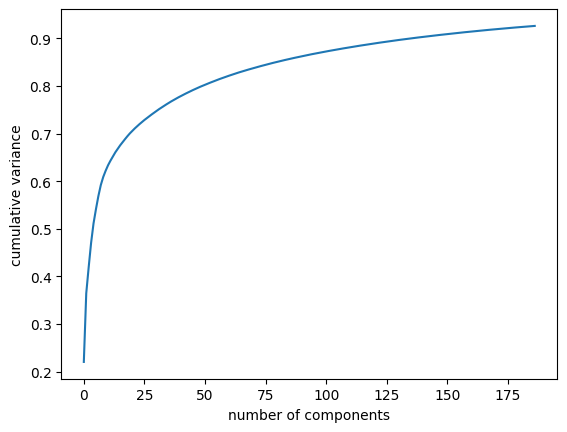

In [4]:
pca = PCA(n_components=187, random_state=42)

X_train_pca =pca.fit_transform(X_train)
X_val_pca = pca.transform(X_val)    # transform -> 트레이닝셋으로 부터 뽑은 주성분에 투영
X_train_PCA1 = pd.DataFrame(X_train_pca)
X_val_PCA1 = pd.DataFrame(X_val_pca)

plt.plot(np.cumsum(pca.explained_variance_ratio_))
plt.xlabel('number of components')
plt.ylabel('cumulative variance')

test_pca = pca.transform(test_X)
test_PCA = pd.DataFrame(test_pca)


## Tuning

In [5]:
start = time.time()

param_grid = {'C': [0.1, 1, 8], 'kernel': ['rbf'],
               'gamma': ['scale', 'auto']}
svc = SVC(**param_grid, probability=True)

grid_search = GridSearchCV(svc, param_grid, scoring ='accuracy', cv=2) # cv -> 교차검증을 위한 fold 횟수
grid_search.fit(X_train_PCA1, label_train)

best_params = grid_search.best_params_
print("best parameters:",grid_search.best_params_)
best_svc = grid_search.best_estimator_


# 정확도 평가
train_pred = best_svc.predict(X_train_PCA1)
val_pred = best_svc.predict(X_val_PCA1)
# X_test_pca
svc_train = metrics.accuracy_score(label_train,train_pred)
svc_accuracy = metrics.accuracy_score(label_val, val_pred)

print("Train Accuracy score: {}".format(svc_train))
print("Validation Accuracy score: {}".format(svc_accuracy))
print(metrics.classification_report(label_val, val_pred))

end = time.time()
svm_time = end-start
print("SVM Time: {:0.2f} minute".format(svm_time/60.0))

best parameters: {'C': 8, 'gamma': 'scale', 'kernel': 'rbf'}
Train Accuracy score: 0.9578703703703704
Validation Accuracy score: 0.9041666666666667
              precision    recall  f1-score   support

           0       0.84      0.87      0.85       574
           1       0.99      0.98      0.99       596
           2       0.83      0.83      0.83       573
           3       0.91      0.94      0.93       624
           4       0.86      0.85      0.86       635
           5       0.98      0.96      0.97       632
           6       0.76      0.70      0.73       600
           7       0.94      0.97      0.95       604
           8       0.95      0.98      0.97       598
           9       0.97      0.95      0.96       564

    accuracy                           0.90      6000
   macro avg       0.90      0.90      0.90      6000
weighted avg       0.90      0.90      0.90      6000

SVM Time: 67.74 minute


# Ensemble

In [6]:
# svm_model1 = SVC(kernel='linear', C=1.0, random_state=42)
# svm_model2 = SVC(kernel='rbf', C=1.0, gamma='scale', random_state=42)
# svm_model3 = SVC(kernel='poly', degree=3, C=1.0, random_state=42)

# # Create a VotingClassifier with the individual models
# voting_classifier = VotingClassifier(estimators=[
#     ('linear_svm', svm_model1),
#     ('rbf_svm', svm_model2),
#     ('poly_svm', svm_model3)
# ], voting='hard')  # 'hard' for majority voting, 'soft' for weighted voting based on confidence scores


## Apply To Test Data

In [7]:
test_pred = best_svc.predict(test_PCA)
# 자르는게 맞는지?
# clip = test_pred[:10000]
with open("./mAP/testResult.txt", "w") as f:
    for f_name, prediction in zip(file_names,test_pred):
        f_name = f_name.replace(".png","")
        f.write(f"{f_name} {prediction}\n")


# 추가할 것
# data augumentation
# ensemble